In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.optim as optim
import pickle

# Подготовка датасета

In [2]:
products = pd.read_csv("products.csv")
transactions = pd.read_csv("transactions.csv")

In [3]:
users_embeddings = transactions.groupby("user_id").agg({"product_id": "count", "reordered": "sum"}).rename(columns={"product_id": "n_bought"}).reset_index()

In [4]:
users_embeddings.rename

<bound method DataFrame.rename of        user_id  n_bought  reordered
0            1        59       41.0
1            2       195       93.0
2            3        82       49.0
3            7       206      138.0
4           13        81       52.0
...        ...       ...        ...
99995   206202       183      120.0
99996   206206       282      132.0
99997   206207       210      118.0
99998   206208       660      465.0
99999   206209       129       61.0

[100000 rows x 3 columns]>

In [5]:
products_embeddings = transactions.groupby("product_id").agg({"order_id": "count", "reordered": "sum"}).reset_index()

In [6]:
y = transactions.groupby(["product_id", "user_id"])["reordered"].agg("max").reset_index()

In [7]:
y

,product_id,user_id,reordered
0,1,138,1.0
1,1,777,0.0
2,1,1052,1.0
3,1,1480,1.0
4,1,1494,1.0
...,...,...,...
9459060,49688,178752,1.0
9459061,49688,184081,0.0
9459062,49688,187523,0.0
9459063,49688,188073,1.0


In [8]:
users_embeddings.rename(columns={"reordered": "user_reorders"}, inplace=True)

In [9]:
products_embeddings.columns = ["product_id", "product_total_orders", "protuct_total_reordered"]

In [10]:
df = pd.merge(pd.merge(y, users_embeddings), products_embeddings)

In [11]:
df.head()

,product_id,user_id,reordered,n_bought,user_reorders,product_total_orders,protuct_total_reordered
0,1,138,1.0,148,93.0,1549,1051.0
1,1,777,0.0,113,83.0,1549,1051.0
2,1,1052,1.0,48,24.0,1549,1051.0
3,1,1480,1.0,192,141.0,1549,1051.0
4,1,1494,1.0,158,87.0,1549,1051.0


In [12]:
normalize = lambda x: preprocessing.MinMaxScaler().fit(x).transform(x)

In [13]:
Xp = normalize(df[products_embeddings.columns])
Xu = normalize(df[users_embeddings.columns])
y = normalize(df[["reordered"]])

# Обучение нейросети

In [14]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, xu, xp):
        x = torch.cat((xu, xp), 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

In [15]:
# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.xu = torch.from_numpy(X[0].astype(np.float32))
        self.xp = torch.from_numpy(X[1].astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.xu.shape[0]
       
    def __getitem__(self, index):
        return self.xu[index], self.xp[index], self.y[index]
   
    def __len__(self):
        return self.len

In [16]:
model = Net()
loss_fn = nn.BCELoss()
model = model.to("cuda")

In [17]:
batch_size = 1024 * 128

# Instantiate training and test data
train_data = Data([Xu, Xp], y)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 30
loss_values = []

for epoch in tqdm(range(num_epochs)):
    for xu, xp, y in train_dataloader:
        xu = xu.to("cuda")
        xp = xp.to("cuda")
        y = y.to("cuda")
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        pred = model(xu, xp)
        loss = loss_fn(pred, y.unsqueeze(-1)[:,:,0])
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

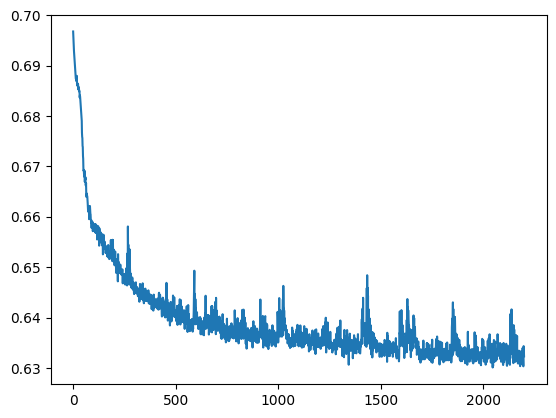

In [27]:
from matplotlib import pyplot as plt
plt.plot(loss_values)
plt.show()

# Предсказания

In [28]:
model = model.to("cpu")

In [29]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

In [30]:
predictions = []

for xu, xp, y in tqdm(train_dataloader):
    pred = model(xu, xp)
    predictions.append(pred.detach().numpy())

100%|██████████| 73/73 [02:01<00:00,  1.67s/it]


In [31]:
df["predictions"] = np.vstack(predictions)

In [32]:
ranked_lists = df.sort_values(["user_id", "predictions"], ascending=False).groupby("user_id")["product_id"].agg(list)

In [33]:
df.to_csv("predictions_.csv")

top 10 sales

In [34]:
top_20 = list(transactions.groupby("product_id")["user_id"].agg("count").sort_values()[-20:].sort_values(ascending=False).keys())

In [35]:
def fill_10(row):
    if len(row) == 10:
        return row.product_id
    pids = row.product_id
    diff = set(top_20) - set(pids)
    unique_top_ranged = [p for p in top_20 if p in diff]
    res = pids + unique_top_ranged
    return res[:10]

In [36]:
ranked_lists = ranked_lists.reset_index()
predictions_list = ranked_lists.apply(fill_10, axis=1)
ranked_lists.product_id = predictions_list
ranked_lists.product_id = ranked_lists.product_id.apply(lambda x: " ".join(map(str, x)))
ranked_lists.columns = ["user_id", "product_id"]
ranked_lists.to_csv("sample_submission_3.csv", index=False)